In [73]:
import math
import collections
import torch
from torch import nn
import torch.nn.utils as nn_utils 
import matplotlib.pyplot as plt
from d2l import torch as d2l

In [22]:
# ---------------------------
# PART 1 : TASK 1
# ---------------------------

# ------------------------------
# Additive (Bahdanau) Attention
# ------------------------------
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout=0.1):
        super().__init__()
        self.W_q = nn.Linear(num_hiddens, num_hiddens, bias=False)
        self.W_k = nn.Linear(num_hiddens, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        # queries: (batch, num_queries, num_hiddens)
        # keys/values: (batch, num_keys, num_hiddens)
        if valid_lens is not None and valid_lens.dim() == 1:
            valid_lens = valid_lens.unsqueeze(1).expand(-1, queries.shape[1]).reshape(-1)
        queries = self.W_q(queries).unsqueeze(2)    # (batch, num_queries, 1, num_hiddens)
        keys    = self.W_k(keys).unsqueeze(1)         # (batch, 1, num_keys, num_hiddens)
        features = torch.tanh(queries + keys)
        scores = self.w_v(features).squeeze(-1)         # (batch, num_queries, num_keys)
        self.attention_weights = d2l.masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [23]:
# ------------------------------
# Seq2Seq Attention Decoder
# ------------------------------
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0.1):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        if X.dim() == 1:
            X = X.unsqueeze(1)
        X = self.embedding(X).permute(1, 0, 2)
        enc_outputs, hidden_state, enc_valid_lens = state
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [24]:
# ------------------------------
# Seq2Seq Model with Attention
# ------------------------------
class Seq2SeqAttention(d2l.EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.tgt_pad = tgt_pad
        self.lr = lr
        self.save_hyperparameters()
    
    def forward(self, X, X_valid_len, Y, Y_valid_len=None):
        enc_outputs = self.encoder(X, X_valid_len)
        dec_state = self.decoder.init_state(enc_outputs, X_valid_len)
        Y_hat, _ = self.decoder(Y, dec_state)
        return Y_hat
    
    def loss(self, Y_hat, Y):
        logits = Y_hat.reshape(-1, Y_hat.shape[-1])
        labels = Y.reshape(-1)
        loss_values = nn.functional.cross_entropy(logits, labels, reduction='none')
        mask = (labels != self.tgt_pad).float()
        return (loss_values * mask).sum() / mask.sum()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [25]:
# ------------------------------
# Override training_step for MTFraEng batches
# ------------------------------
@d2l.add_to_class(Seq2SeqAttention)
def training_step(self, batch):
    if len(batch) == 3:
        src, tgt, src_valid_len = batch
    else:
        src, tgt, src_valid_len, _ = batch
    Y_hat = self(src, src_valid_len, tgt, None)
    return self.loss(Y_hat, tgt)

In [26]:
# Hyperparameter Configurations
configs = [
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2},
    {'embed_size': 256, 'num_hiddens': 512, 'num_layers': 2, 'lr': 0.001, 'dropout': 0.2},
    {'embed_size': 512, 'num_hiddens': 512, 'num_layers': 3, 'lr': 0.002, 'dropout': 0.1},
    {'embed_size': 512, 'num_hiddens': 1024, 'num_layers': 3, 'lr': 0.001, 'dropout': 0.3},
    {'embed_size': 256, 'num_hiddens': 512, 'num_layers': 4, 'lr': 0.0005, 'dropout': 0.2},
]

In [27]:
# ------------------------------
# Extend predict_step for inference
# ------------------------------
@d2l.add_to_class(d2l.EncoderDecoder)
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch = [x.to(device) for x in batch]
    if len(batch) == 3:
        src, tgt, src_valid_len = batch
    else:
        src, tgt, src_valid_len, _ = batch
    enc_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, 0].unsqueeze(1)], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(dim=2))
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], dim=1), attention_weights

In [28]:
# ------------------------------
# BLEU Score Calculation Function
# ------------------------------
def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            ngram = ' '.join(pred_tokens[i: i + n])
            if label_subs[ngram] > 0:
                num_matches += 1
                label_subs[ngram] -= 1
        score *= (num_matches / (len_pred - n + 1)) ** (0.5 ** n)
    return score

In [29]:
# ------------------------------
# Hyperparameter Configurations (5 configs)
# ------------------------------
configs = [
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2},
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.003, 'dropout': 0.2},
    {'embed_size': 256, 'num_hiddens': 512, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2},
    {'embed_size': 512, 'num_hiddens': 512, 'num_layers': 3, 'lr': 0.001, 'dropout': 0.3},
    {'embed_size': 512, 'num_hiddens': 1024, 'num_layers': 3, 'lr': 0.0002, 'dropout': 0.3}
]



Translations:
go . => ['<unk>', '!'], BLEU: 0.000
i lost . => ["j'ai", 'gagné', '.'], BLEU: 0.000
he's calm . => ['il', 'est', '.'], BLEU: 0.603
i'm home . => ['je', 'suis', 'bien', '.'], BLEU: 0.512
Average BLEU for Config 5: 0.279


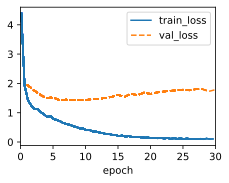

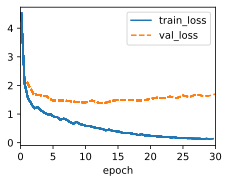

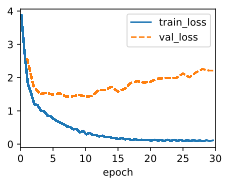

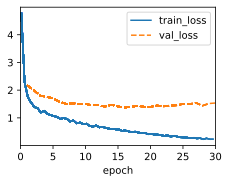

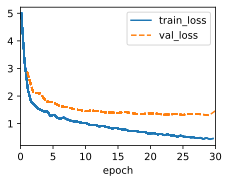

In [30]:
# ------------------------------
# Training Execution, BLEU Evaluation, and Storing Translations
# ------------------------------
data = d2l.MTFraEng(batch_size=128)
history_dict = {}    # Optional: if your Trainer records loss history
bleu_scores = []
translations_dict = {}  # To store translations for each configuration
device = d2l.try_gpu()

for i, config in enumerate(configs, start=1):
    print(f"\n=== Training Config {i} ===")
    print(config)
    # Build encoder and decoder per config.
    encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), config['embed_size'], 
                                 config['num_hiddens'], config['num_layers'], 
                                 config['dropout'])
    decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), config['embed_size'], 
                                      config['num_hiddens'], config['num_layers'], 
                                      config['dropout'])
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], 
                        lr=config['lr'])
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer.fit(model, data)
    # Optionally record loss history if available (if not, skip this step)
    # history_dict[f'Config {i}'] = (trainer.history["train_loss"], trainer.history["val_loss"])
    
    # BLEU Evaluation and Translation Storage for current config:
    engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
    fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
    preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)

    current_translations = []  # Store output for each sample sentence.
    config_bleus = []
    print("\nTranslations:")
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>':
                break
            translation.append(token)
        # Remove any <pad> tokens.
        translation = [t for t in translation if t != '<pad>']
        bleu_score = d2l.bleu(" ".join(translation), fr, k=2)
        config_bleus.append(bleu_score)
        print(f"{en} => {translation}, BLEU: {bleu_score:.3f}")
        current_translations.append({
            "source": en,
            "target": fr,
            "translation": translation,
            "bleu": bleu_score
        })
    avg_bleu = sum(config_bleus) / len(config_bleus)
    bleu_scores.append(avg_bleu)
    translations_dict[f"Config {i}"] = current_translations
    print(f"Average BLEU for Config {i}: {avg_bleu:.3f}")

In [31]:
# ------------------------------
# 9. Display BLEU Scores Summary and Translations
# ------------------------------
print("\nBLEU Scores Summary:")
for i, score in enumerate(bleu_scores, start=1):
    print(f"Config {i}: {score:.3f}")

print("\nDetailed Translations:")
for config_name, translations in translations_dict.items():
    print(f"\n{config_name}:")
    for trans in translations:
        print(f"  {trans['source']} => {trans['translation']}, BLEU: {trans['bleu']:.3f}")


BLEU Scores Summary:
Config 1: 0.884
Config 2: 0.750
Config 3: 0.915
Config 4: 0.551
Config 5: 0.279

Detailed Translations:

Config 1:
  go . => ['va', '!'], BLEU: 1.000
  i lost . => ["j'ai", 'perdu', '.'], BLEU: 1.000
  he's calm . => ['je', 'suis', 'calme', '.'], BLEU: 0.537
  i'm home . => ['je', 'suis', 'chez', 'moi', '.'], BLEU: 1.000

Config 2:
  go . => ['va', '!'], BLEU: 1.000
  i lost . => ["j'ai", 'perdu', '.'], BLEU: 1.000
  he's calm . => ['je', 'suis', 'de', 'la', 'partie', '.'], BLEU: 0.000
  i'm home . => ['je', 'suis', 'chez', 'moi', '.'], BLEU: 1.000

Config 3:
  go . => ['va', '!'], BLEU: 1.000
  i lost . => ["j'ai", 'perdu', '.'], BLEU: 1.000
  he's calm . => ['il', 'est', 'mouillé', '.'], BLEU: 0.658
  i'm home . => ['je', 'suis', 'chez', 'moi', '.'], BLEU: 1.000

Config 4:
  go . => ['va', '!'], BLEU: 1.000
  i lost . => ["j'ai", '<unk>', '.'], BLEU: 0.000
  he's calm . => ['il', 'est', 'mouillé', '.'], BLEU: 0.658
  i'm home . => ['je', 'suis', 'en', 'retard', 

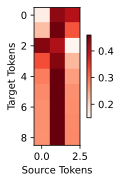

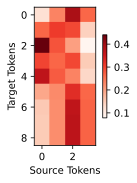

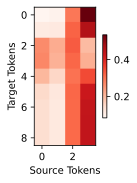

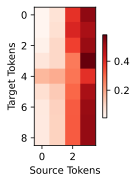

In [35]:
# ---- PART 1: TASK 2 ----

# # List of sample sentence pairs to visualize:
engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']

# For each sentence pair, generate and plot the attention heatmap.
for src, tgt in zip(engs, fras):
    batch = data.build([src], [tgt])
    _, dec_attention_weights = model.predict_step(batch, d2l.try_gpu(), data.num_steps, True)
    attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights], 0)
    attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))
    
    # We add one to include the <eos> token in the source sequence, if appropriate.
    num_keys = len(src.split()) + 1  
    # Plot the heatmap.
    d2l.show_heatmaps(
        attention_weights[:, :, :, :num_keys].cpu(),
        xlabel='Source Tokens', ylabel='Target Tokens'
    )



In [32]:
# ---- PART 2: TASK 1----
# ---------------------------------------------------------------------
# Multi-Head Attention Module (based on D2L reference)
# ---------------------------------------------------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, num_hiddens, num_heads, dropout=0.1, bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.num_hiddens = num_hiddens
        self.dim_per_head = num_hiddens // num_heads
        self.W_q = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.W_k = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.W_v = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        # queries, keys, values: (batch, num_items, num_hiddens)
        queries = self.W_q(queries)   # (batch, num_queries, num_hiddens)
        keys    = self.W_k(keys)       # (batch, num_keys, num_hiddens)
        values  = self.W_v(values)     # (batch, num_keys, num_hiddens)
        queries = self._transpose_qkv(queries)  # (batch*num_heads, num_queries, dim_per_head)
        keys = self._transpose_qkv(keys)        # (batch*num_heads, num_keys, dim_per_head)
        values = self._transpose_qkv(values)    # (batch*num_heads, num_keys, dim_per_head)
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(self.dim_per_head)
        if valid_lens is not None:
            valid_lens = valid_lens.repeat_interleave(self.num_heads, dim=0)
        self._attn_weights = d2l.masked_softmax(scores, valid_lens)
        attn = self.dropout(self._attn_weights)
        output = torch.bmm(attn, values)  # (batch*num_heads, num_queries, dim_per_head)
        output = self._transpose_output(output)  # (batch, num_queries, num_hiddens)
        return self.W_o(output)
    
    def _transpose_qkv(self, X):
        batch, num_items, num_hiddens = X.shape
        X = X.reshape(batch, num_items, self.num_heads, self.dim_per_head)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(-1, num_items, self.dim_per_head)
    
    def _transpose_output(self, X):
        batch_times_heads, num_items, _ = X.shape
        batch = batch_times_heads // self.num_heads
        X = X.reshape(batch, self.num_heads, num_items, self.dim_per_head)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(batch, num_items, self.num_hiddens)
    
    @property
    def attention_weights(self):
        return self._attn_weights

In [33]:
###############################################################################
# Multi-Head Attention Decoder from an elready defined single head decoder
###############################################################################
def build_multihead_decoder(vocab_size, embed_size, num_hiddens, num_layers, dropout, num_heads):
    """
    Returns a multi-head attention decoder by extending your existing single-head decoder.
    """
    class Seq2SeqMultiHeadAttentionDecoder(Seq2SeqAttentionDecoder):
        def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, num_heads, dropout=0.1):
            super().__init__(vocab_size, embed_size, num_hiddens, num_layers, dropout)
            self.multihead_attention = MultiHeadAttention(num_hiddens, num_heads, dropout)
        def forward(self, X, state):
            if X.dim() == 1:
                X = X.unsqueeze(1)
            X = self.embedding(X).permute(1, 0, 2)
            enc_outputs, hidden_state, enc_valid_lens = state
            outputs, self._attention_weights = [], []
            for x in X:
                query = hidden_state[-1].unsqueeze(1)
                context = self.multihead_attention(query, enc_outputs, enc_outputs, enc_valid_lens)
                x = torch.cat((context, x.unsqueeze(1)), dim=-1)
                out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
                outputs.append(out)
                self._attention_weights.append(self.multihead_attention.attention_weights)
            outputs = self.dense(torch.cat(outputs, dim=0))
            return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
        @property
        def attention_weights(self):
            return self._attention_weights
    return Seq2SeqMultiHeadAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers, num_heads, dropout)


In [34]:
# ---------------------------------------------------------------------
# Build Multi-Head Seq2Seq Model
# ---------------------------------------------------------------------
def build_model(data, config, use_multihead=True):
    encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), config['embed_size'],
                                 config['num_hiddens'], config['num_layers'],
                                 config['dropout'])
    if use_multihead:
        decoder = build_multihead_decoder(len(data.tgt_vocab),
                                          config['embed_size'],
                                          config['num_hiddens'],
                                          config['num_layers'],
                                          config['dropout'],
                                          config['num_heads'])
    else:
        decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab),
                                          config['embed_size'],
                                          config['num_hiddens'],
                                          config['num_layers'],
                                          config['dropout'])
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                         lr=config['lr'])
    return model

In [35]:
# ---------------------------------------------------------------------
# Custom Trainer to Safely Clip Gradients
# ---------------------------------------------------------------------
class MyTrainer(d2l.Trainer):
    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad and p.grad is not None]
        norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
        if norm > grad_clip_val:
            for p in params:
                p.grad[:] = p.grad * (grad_clip_val / norm)

def train_model(model, data, num_epochs=30, gradient_clip_val=1, num_gpus=1):
    trainer = MyTrainer(max_epochs=num_epochs, gradient_clip_val=gradient_clip_val, num_gpus=num_gpus)
    trainer.fit(model, data)
    return trainer

In [36]:
# ---------------------------------------------------------------------
# Evaluation Function: Print Translations and BLEU Scores
# ---------------------------------------------------------------------
def evaluate_translations(model, data, device):
    engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
    fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
    preds, _ = model.predict_step(data.build(engs, fras), device, data.num_steps)
    translations = []
    bleu_list = []
    print("\nTranslations:")
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>': break
            translation.append(token)
        translation = [t for t in translation if t != '<pad>']
        b = d2l.bleu(" ".join(translation), fr, k=2)
        print(f"{en} => {translation}, BLEU: {b:.3f}")
        translations.append({"source": en, "target": fr, "translation": translation, "bleu": b})
        bleu_list.append(b)
    avg_bleu = sum(bleu_list) / len(bleu_list)
    return avg_bleu, translations

In [37]:
# ---------------------------------------------------------------------
# Attention Visualization Function
# ---------------------------------------------------------------------
def visualize_attention(model, data, device, src_sent, tgt_sent):
    batch = data.build([src_sent], [tgt_sent])
    _, dec_attn = model.predict_step(batch, device, data.num_steps, True)
    # Concatenate attention weights for each decoding step.
    attn = torch.cat([step[0][0][0] for step in dec_attn], 0)
    attn = attn.reshape((1, 1, -1, data.num_steps))
    num_keys = len(src_sent.split()) + 1  # source tokens + <eos>
    d2l.show_heatmaps(
        attn[:, :, :, :num_keys].cpu(),
        xlabel='Source Tokens',
        ylabel='Target Tokens'
    )

In [38]:
# ---------------------------------------------------------------------
# Experiment Runner for Multi-Head Attention
# ---------------------------------------------------------------------
def run_experiments(data, device, configs):
    results = []
    for i, config in enumerate(configs, start=1):
        print(f"\n=== Multi-Head Config {i} (num_heads = {config['num_heads']}) ===")
        print(config)
        model = build_model(data, config, use_multihead=True)
        trainer = train_model(model, data)
        avg_bleu, translations = evaluate_translations(model, data, device)
        results.append({"config_index": i, "config": config, "avg_bleu": avg_bleu, "translations": translations})
        print(f"Average BLEU for Config {i} (num_heads={config['num_heads']}): {avg_bleu:.3f}")
        # Visualize attention for two selected sentence pairs:
        for src, tgt in [("i lost .", "j'ai perdu ."), ("go .", "va !")]:
            visualize_attention(model, data, device, src, tgt)
    return results


Translations:
go . => ['va', '!'], BLEU: 1.000
i lost . => ["j'ai", 'perdu', '.'], BLEU: 1.000
he's calm . => ['elle', 'est', '<unk>', '.'], BLEU: 0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], BLEU: 1.000
Average BLEU for Config 4 (num_heads=8): 0.750

Detailed Translations (Multi-Head):
------------------------------------------------------------
Configuration 1 (num_heads = 1)
Average BLEU: 0.884

Source:  go .
Target:  va !
Output:  ['va', '!']
BLEU:    1.000
------------------------------
Source:  i lost .
Target:  j'ai perdu .
Output:  ["j'ai", 'perdu', '.']
BLEU:    1.000
------------------------------
Source:  he's calm .
Target:  il est calme .
Output:  ['je', 'suis', 'calme', '.']
BLEU:    0.537
------------------------------
Source:  i'm home .
Target:  je suis chez moi .
Output:  ['je', 'suis', 'chez', 'moi', '.']
BLEU:    1.000
------------------------------
------------------------------------------------------------
---------------------------------------------

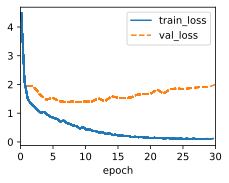

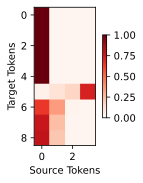

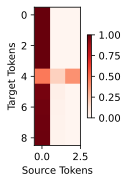

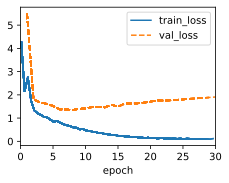

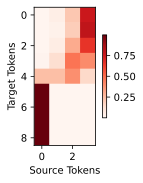

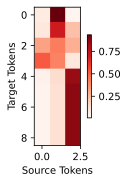

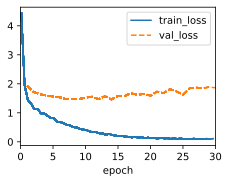

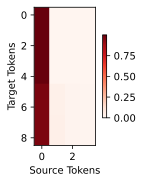

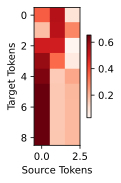

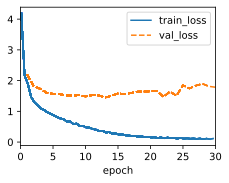

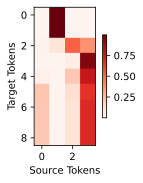

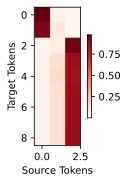

In [39]:
# ------------ PART2- TASK 2 -------------------------------------
# Define multi-head configurations (example: 1, 2, 4, and 8 heads)
multihead_configs = [
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2, 'num_heads': 1},
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2, 'num_heads': 2},
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2, 'num_heads': 4},
    {'embed_size': 256, 'num_hiddens': 256, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.2, 'num_heads': 8},
]

data = d2l.MTFraEng(batch_size=128)
device = d2l.try_gpu()

results = run_experiments(data, device, multihead_configs)

print("\nDetailed Translations (Multi-Head):")
for res in results:
    print("-" * 60)
    print(f"Configuration {res['config_index']} (num_heads = {res['config']['num_heads']})")
    print(f"Average BLEU: {res['avg_bleu']:.3f}\n")
    for trans in res['translations']:
        print(f"Source:  {trans['source']}")
        print(f"Target:  {trans['target']}")
        print(f"Output:  {trans['translation']}")
        print(f"BLEU:    {trans['bleu']:.3f}")
        print("-" * 30)
    print("-" * 60)


In [40]:
# ---------------------- PART 3 -------------------------------
# ---------------------------------------------
# Own Transformer Model with D2L as a reference
# ---------------------------------------------

# ---------------------------------------------------------------------
# 1. PositionWiseFFN: feed-forward net with ReLU
# ---------------------------------------------------------------------
class PositionWiseFFN(nn.Module):
    """Feed-forward network used in the Transformer."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


In [49]:
# ---------------------------------------------------------------------
# AddNorm: residual connection followed by layer normalization
# ---------------------------------------------------------------------
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [50]:
# ---------------------------------------------------------------------
# Transformer Encoder Block
# ---------------------------------------------------------------------
class TransformerEncoderBlock(nn.Module):
    """One block of the Transformer encoder."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
    
    def forward(self, X, valid_lens):
        # Multi-head self-attention
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        # Positionwise feed-forward
        return self.addnorm2(Y, self.ffn(Y))

In [51]:
# ---------------------------------------------------------------------
# Transformer Encoder
# ---------------------------------------------------------------------
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder: stack of 'num_blks' encoder blocks."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential(*[
            TransformerEncoderBlock(num_hiddens, ffn_num_hiddens,
                                    num_heads, dropout)
            for _ in range(num_blks)
        ])
    
    def forward(self, X, valid_lens):
        # Rescale embeddings by sqrt of num_hiddens, then add positional encoding
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # Pass through encoder blocks
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X


In [52]:
# ---------------------------------------------------------------------
# Transformer Decoder Block
# ---------------------------------------------------------------------
class TransformerDecoderBlock(nn.Module):
    """One block of the Transformer decoder."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.self_attn = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.enc_dec_attn = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # Because we allow decoding in training (full sequence) or inference (partial):
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        # Self-attention in the decoder
        Y = self.addnorm1(X, self.self_attn(X, X, X, dec_valid_lens))
        # Encoder-decoder attention
        Z = self.addnorm2(Y, self.enc_dec_attn(Y, enc_outputs, enc_outputs, enc_valid_lens))
        return self.addnorm3(Z, self.ffn(Z)), state

In [53]:
# ---------------------------------------------------------------------
# Transformer Decoder
# ---------------------------------------------------------------------
class TransformerDecoder(d2l.AttentionDecoder):
    """Transformer decoder: stack of 'num_blks' decoder blocks."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential(*[
            TransformerDecoderBlock(num_hiddens, ffn_num_hiddens,
                                    num_heads, dropout, i)
            for i in range(num_blks)
        ])
        self.dense = nn.LazyLinear(vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None]*self.num_blks]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state

In [54]:
# ---------------------------------------------------------------------
# Building the Transformer Seq2Seq Model
# ---------------------------------------------------------------------
def build_transformer(vocab_size_src, vocab_size_tgt, num_hiddens,
                      ffn_num_hiddens, num_heads, num_blks, dropout, lr):
    encoder = TransformerEncoder(vocab_size_src, num_hiddens, ffn_num_hiddens,
                                 num_heads, num_blks, dropout)
    decoder = TransformerDecoder(vocab_size_tgt, num_hiddens, ffn_num_hiddens,
                                 num_heads, num_blks, dropout)
    net = d2l.Seq2Seq(encoder, decoder,
                      tgt_pad=vocab_size_tgt-1,  # We'll fix below
                      lr=lr)
    return net

In [55]:
# ---------------------------------------------------------------------
# 8. Evaluate on sample sentences: Print translations and BLEU
# ---------------------------------------------------------------------
def evaluate_transformer(net, data, device):
    engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
    fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
    preds, _ = net.predict_step(data.build(engs, fras), device, data.num_steps)
    
    current_translations = []
    config_bleus = []
    print("\nTranslations:")
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>':
                break
            translation.append(token)
        # Remove <pad> tokens
        translation = [t for t in translation if t != '<pad>']
        bleu_score = d2l.bleu(" ".join(translation), fr, k=2)
        config_bleus.append(bleu_score)
        print(f"{en} => {translation}, BLEU: {bleu_score:.3f}")
        current_translations.append({
            "source": en,
            "target": fr,
            "translation": translation,
            "bleu": bleu_score
        })
    avg_bleu = sum(config_bleus) / len(config_bleus)
    print(f"Average BLEU: {avg_bleu:.3f}")
    return avg_bleu, current_translations


Evaluating Translations:

Translations:
go . => ['va', '!'], BLEU: 1.000
i lost . => ["j'ai", 'perdu', '.'], BLEU: 1.000
he's calm . => ['<unk>', '.'], BLEU: 0.000
i'm home . => ['je', 'suis', '.'], BLEU: 0.432
Average BLEU: 0.608

=== Detailed Translations (Transformer) ===
------------------------------------------------------------
Config 1 (num_heads=2, FFN=64):
Average BLEU: 0.915

Source:  go .
Target:  va !
Output:  ['va', '!']
BLEU:    1.000
------------------------------
Source:  i lost .
Target:  j'ai perdu .
Output:  ["j'ai", 'perdu', '.']
BLEU:    1.000
------------------------------
Source:  he's calm .
Target:  il est calme .
Output:  ['il', 'est', 'venu', '.']
BLEU:    0.658
------------------------------
Source:  i'm home .
Target:  je suis chez moi .
Output:  ['je', 'suis', 'chez', 'moi', '.']
BLEU:    1.000
------------------------------
------------------------------------------------------------
------------------------------------------------------------
Config 2 

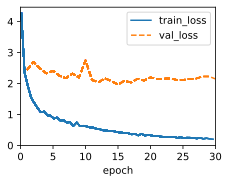

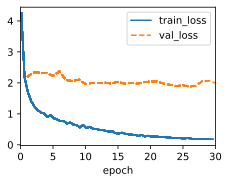

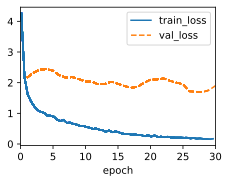

In [56]:
# ---------------------------------------------------------------------
# Run Transformer Experiments with Multiple Hyperparameter Configurations
# ---------------------------------------------------------------------

# Create the English–French dataset instance
data = d2l.MTFraEng(batch_size=128)
device = d2l.try_gpu()

# Define three Transformer configurations (e.g., varying feed-forward size and number of heads)
configs = [
    {'num_hiddens': 256, 'ffn_num_hiddens': 64,  'num_heads': 2, 'num_blks': 2, 'dropout': 0.2, 'lr': 0.001},
    {'num_hiddens': 256, 'ffn_num_hiddens': 128, 'num_heads': 4, 'num_blks': 2, 'dropout': 0.2, 'lr': 0.001},
    {'num_hiddens': 256, 'ffn_num_hiddens': 256, 'num_heads': 8, 'num_blks': 2, 'dropout': 0.2, 'lr': 0.001},
]

results = []
for i, cfg in enumerate(configs, start=1):
    print(f"\n=== Transformer Config {i} ===")
    print(cfg)
    net = build_transformer(len(data.src_vocab), len(data.tgt_vocab),
                            cfg['num_hiddens'], cfg['ffn_num_hiddens'],
                            cfg['num_heads'], cfg['num_blks'],
                            cfg['dropout'], cfg['lr'])
    trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer.fit(net, data)  # Training without per-epoch printouts here.
    print("\nEvaluating Translations:")
    avg_bleu, translations = evaluate_transformer(net, data, device)
    results.append((i, cfg, avg_bleu, translations))

# Print detailed translations for all configurations:
print("\n=== Detailed Translations (Transformer) ===")
for (idx, cfg, bleu, trans) in results:
    print("-" * 60)
    print(f"Config {idx} (num_heads={cfg['num_heads']}, FFN={cfg['ffn_num_hiddens']}):")
    print(f"Average BLEU: {bleu:.3f}\n")
    for t in trans:
        print(f"Source:  {t['source']}")
        print(f"Target:  {t['target']}")
        print(f"Output:  {t['translation']}")
        print(f"BLEU:    {t['bleu']:.3f}")
        print("-" * 30)
    print("-" * 60)
        


In [65]:
# ---------------------------------------------------------------------
# Ablated Transformer Encoder Block
# ---------------------------------------------------------------------
class AblatedTransformerEncoderBlock(nn.Module):
    """A Transformer encoder block with options to disable self-attention."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_self_attn=True):
        super().__init__()
        self.use_self_attn = use_self_attn
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=dropout) if use_self_attn else None
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
    
    def forward(self, X, valid_lens):
        if self.use_self_attn:
            Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        else:
            Y = X
        return self.addnorm2(Y, self.ffn(Y))

In [66]:
# Ablated Transformer Encoder
# ---------------------------------------------------------------------
class AblatedTransformerEncoder(d2l.Encoder):
    """The Transformer encoder with ablation options."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, use_pos_enc=True, use_self_attn=True):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # If positional encoding is disabled, use the identity function.
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) if use_pos_enc else nn.Identity()
        self.blks = nn.Sequential(*[
            AblatedTransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_self_attn)
            for _ in range(num_blks)
        ])
    
    def forward(self, X, valid_lens):
        X = self.embedding(X) * math.sqrt(self.num_hiddens)
        X = self.pos_encoding(X)
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X


In [67]:
# Ablated Transformer Decoder Block
# ---------------------------------------------------------------------
class AblatedTransformerDecoderBlock(nn.Module):
    """One block of the Transformer decoder with option to disable self-attention."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i, use_self_attn=True):
        super().__init__()
        self.i = i
        self.use_self_attn = use_self_attn
        self.self_attn = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=dropout) if use_self_attn else None
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.enc_dec_attn = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout=dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if self.training and self.use_self_attn:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        if self.use_self_attn:
            Y = self.addnorm1(X, self.self_attn(X, X, X, dec_valid_lens))
        else:
            Y = X
        Z = self.addnorm2(Y, self.enc_dec_attn(Y, enc_outputs, enc_outputs, enc_valid_lens))
        return self.addnorm3(Z, self.ffn(Z)), state

In [68]:
# ---------------------------------------------------------------------
# Ablated Transformer Decoder
# ---------------------------------------------------------------------
class AblatedTransformerDecoder(d2l.AttentionDecoder):
    """The Transformer decoder with ablation options."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, use_pos_enc=True, use_self_attn=True):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) if use_pos_enc else nn.Identity()
        self.blks = nn.Sequential(*[
            AblatedTransformerDecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, i, use_self_attn)
            for i in range(num_blks)
        ])
        self.dense = nn.LazyLinear(vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None]*self.num_blks]
    
    def forward(self, X, state):
        X = self.embedding(X) * math.sqrt(self.num_hiddens)
        X = self.pos_encoding(X)
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state

In [69]:
# ---------------------------------------------------------------------
# Custom SafeTrainer to handle None gradients
# ---------------------------------------------------------------------
class SafeTrainer(d2l.Trainer):
    def clip_gradients(self, grad_clip_val, model):
        # Only clip parameters that have non-None gradients
        params = [p for p in model.parameters() if p.grad is not None]
        nn_utils.clip_grad_norm_(params, grad_clip_val)

In [70]:
# ---------------------------------------------------------------------
# Ablation Transformer Seq2Seq Model
# ---------------------------------------------------------------------
def build_ablation_transformer(vocab_size_src, vocab_size_tgt, num_hiddens, ffn_num_hiddens,
                               num_heads, num_blks, dropout, lr,
                               disable_pos_enc=False, disable_self_attn=False):
    encoder = AblatedTransformerEncoder(
        vocab_size_src, num_hiddens, ffn_num_hiddens, num_heads, num_blks,
        dropout, use_pos_enc=not disable_pos_enc, use_self_attn=not disable_self_attn)
    
    decoder = AblatedTransformerDecoder(
        vocab_size_tgt, num_hiddens, ffn_num_hiddens, num_heads, num_blks,
        dropout, use_pos_enc=not disable_pos_enc, use_self_attn=not disable_self_attn)
    
    # Note: data.tgt_vocab is used to get the <pad> token index.
    net = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=lr)
    return net

In [71]:
# ---------------------------------------------------------------------
# 9. Evaluation: Print Translations and BLEU
# ---------------------------------------------------------------------
def evaluate_transformer(net, data, device):
    engs = ['go .', 'i lost .', "he's calm .", "i'm home ."]
    fras = ['va !', "j'ai perdu .", 'il est calme .', 'je suis chez moi .']
    preds, _ = net.predict_step(data.build(engs, fras), device, data.num_steps)
    current_translations = []
    config_bleus = []
    print("\nTranslations:")
    for en, fr, p in zip(engs, fras, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>': 
                break
            translation.append(token)
        # Filter out any <pad> tokens
        translation = [t for t in translation if t != '<pad>']
        bleu_score = d2l.bleu(" ".join(translation), fr, k=2)
        config_bleus.append(bleu_score)
        print(f"{en} => {translation}, BLEU: {bleu_score:.3f}")
        current_translations.append({
            "source": en,
            "target": fr,
            "translation": translation,
            "bleu": bleu_score
        })
    avg_bleu = sum(config_bleus) / len(config_bleus)
    print(f"Average BLEU: {avg_bleu:.3f}")
    return avg_bleu, current_translations


Translations:
go . => ['va', '!'], BLEU: 1.000
i lost . => ["j'ai", 'perdu', '.'], BLEU: 1.000
he's calm . => ['il', 'est', 'mouillé', '.'], BLEU: 0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], BLEU: 1.000
Average BLEU: 0.915

=== Detailed Translations (Ablation Study) ===
------------------------------------------------------------
Model: Full
Average BLEU: 0.651

Source:  go .
Target:  va !
Output:  ['va', '!']
BLEU:    1.000
------------------------------
Source:  i lost .
Target:  j'ai perdu .
Output:  ['je', 'suis', '.']
BLEU:    0.000
------------------------------
Source:  he's calm .
Target:  il est calme .
Output:  ['il', 'est', '.']
BLEU:    0.603
------------------------------
Source:  i'm home .
Target:  je suis chez moi .
Output:  ['je', 'suis', 'chez', 'moi', '.']
BLEU:    1.000
------------------------------
------------------------------------------------------------
------------------------------------------------------------
Model: No Positional Encoding
Ave

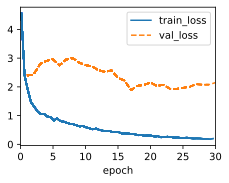

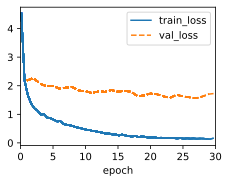

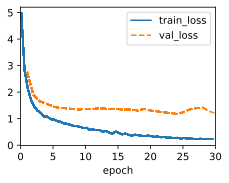

In [74]:
# ---------------------------------------------------------------------
# 10. Run Ablation Experiments
# ---------------------------------------------------------------------
if __name__ == '__main__':
    data = d2l.MTFraEng(batch_size=128)
    device = d2l.try_gpu()
    
    # Common hyperparameters for the Transformer model
    config = {
        'num_hiddens': 256,
        'ffn_num_hiddens': 128,
        'num_heads': 4,
        'num_blks': 2,
        'dropout': 0.2,
        'lr': 0.001
    }
    
    results = {}
    
    # Baseline Transformer (full model)
    print("\n=== Baseline Transformer (Full) ===")
    net_full = build_ablation_transformer(
        len(data.src_vocab), len(data.tgt_vocab),
        config['num_hiddens'], config['ffn_num_hiddens'],
        config['num_heads'], config['num_blks'],
        config['dropout'], config['lr'],
        disable_pos_enc=False, disable_self_attn=False)
    
    trainer_full = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer_full.fit(net_full, data)
    avg_bleu_full, trans_full = evaluate_transformer(net_full, data, device)
    results['Full'] = (avg_bleu_full, trans_full)
    
    # Ablation: Disable Positional Encoding
    print("\n=== Ablation: No Positional Encoding ===")
    net_no_pos = build_ablation_transformer(
        len(data.src_vocab), len(data.tgt_vocab),
        config['num_hiddens'], config['ffn_num_hiddens'],
        config['num_heads'], config['num_blks'],
        config['dropout'], config['lr'],
        disable_pos_enc=True, disable_self_attn=False)
    
    trainer_no_pos = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer_no_pos.fit(net_no_pos, data)
    avg_bleu_no_pos, trans_no_pos = evaluate_transformer(net_no_pos, data, device)
    results['No Positional Encoding'] = (avg_bleu_no_pos, trans_no_pos)
    
    # Ablation: Disable Self-Attention
    print("\n=== Ablation: No Self-Attention ===")
    net_no_self = build_ablation_transformer(
        len(data.src_vocab), len(data.tgt_vocab),
        config['num_hiddens'], config['ffn_num_hiddens'],
        config['num_heads'], config['num_blks'],
        config['dropout'], config['lr'],
        disable_pos_enc=False, disable_self_attn=True)
    
    # Use the custom SafeTrainer to avoid issues with None gradients.
    trainer_no_self = SafeTrainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
    trainer_no_self.fit(net_no_self, data)
    avg_bleu_no_self, trans_no_self = evaluate_transformer(net_no_self, data, device)
    results['No Self-Attention'] = (avg_bleu_no_self, trans_no_self)
    
    # Print detailed translations for all models
    print("\n=== Detailed Translations (Ablation Study) ===")
    for key, (bleu, trans) in results.items():
        print("-" * 60)
        print(f"Model: {key}")
        print(f"Average BLEU: {bleu:.3f}\n")
        for t in trans:
            print(f"Source:  {t['source']}")
            print(f"Target:  {t['target']}")
            print(f"Output:  {t['translation']}")
            print(f"BLEU:    {t['bleu']:.3f}")
            print("-" * 30)
        print("-" * 60)